**NOTEBOOK:**
* https://www.kaggle.com/hachemsfar/deep-learning-project/

**DATASET**
* https://www.kaggle.com/hachemsfar/patent-classification-train
* https://www.kaggle.com/hachemsfar/pattent-classification-test

In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 92kB 1.7MB/s 


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

        
import xml.etree.ElementTree as ET
from sklearn.metrics import f1_score
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
UsageError: Line magic function `%` not found.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [4]:
Training_XML=[]
for dirname, _, filenames in os.walk('/kaggle/input/patent-classification-train'):
    for filename in filenames:
        Training_XML.append(os.path.join(dirname, filename))

In [5]:
Testing_XML=[]
for dirname, _, filenames in os.walk('/kaggle/input/pattent-classification-test'):
    for filename in filenames:
        Testing_XML.append(os.path.join(dirname, filename))

In [6]:
label_training=[]
ab_training=[]
dictionnary_training={}

for i in Training_XML:
    try:
        tree = ET.parse(i)
        root = tree.getroot()
        for abstract in root.iter('ab'):
            if(type(abstract.text)==type("text")):
                ab_training.append(abstract.text)
                label_training.append(i.split("/kaggle/input/patent-classification-train/alphatrain-")[1][0])
                dictionnary_training[abstract.text]=i.split("/kaggle/input/patent-classification-train/alphatrain-")[1][0]
    except:
        print("hachem")


hachem
hachem
hachem
hachem
hachem
hachem
hachem
hachem


In [7]:
len(Training_XML)

46325

In [8]:
len(Testing_XML)

28926

In [9]:
label_testing=[]
ab_testing=[]
dictionnary_testing={}

for i in Testing_XML:
    try:
        tree = ET.parse(i)
        root = tree.getroot()
        for abstract in root.iter('ab'):
            if(type(abstract.text)==type("text")):
                ab_testing.append(abstract.text)
                label_testing.append(i.split("/kaggle/input/pattent-classification-test/alphatest-")[1][0])
                dictionnary_testing[abstract.text]=i.split("/kaggle/input/pattent-classification-test/alphatest-")[1][0]
    except:
        print("hachem")


hachem
hachem


In [10]:
print(len(ab_testing))
print(len(label_testing))
print(set(label_testing))

28878
28878
{'B', 'H', 'E', 'G', 'C', 'D', 'A', 'F'}


In [11]:
print(len(ab_training))
print(len(label_training))
print(set(label_training))

46294
46294
{'B', 'H', 'E', 'G', 'C', 'D', 'A', 'F'}


In [12]:
label=label_training+label_testing
ab=ab_testing+ab_training

In [13]:
print(label.count('A'))
print(label.count('B'))
print(label.count('C'))
print(label.count('D'))
print(label.count('E'))
print(label.count('F'))
print(label.count('G'))
print(label.count('H'))


10950
14688
16233
1710
3025
6685
10260
11621


In [14]:
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in ab]
labels = label

In [15]:
labels_new=[]
tokenized_texts=[]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
for i in range(len(sentences)):
    try:
        tokenized_texts.append([tokenizer.tokenize(sentences[i])])
        labels_new.append(labels[i])
    except:
        print(type(sent))

print ("Tokenize the first sentence:")
print (tokenized_texts[0])

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 4155087.79B/s]


Tokenize the first sentence:
['[CLS]', 'a', 'paving', 'system', 'for', 'controlling', 'drainage', 'and', '/', 'or', 'flow', 'of', 'water', 'on', 'a', 'slope', 'comprises', 'a', 'per', '##me', '##able', 'layer', 'providing', 'an', 'upper', 'surface', '(', '12', ')', ',', 'at', 'least', 'one', 'supporting', 'substrate', 'layer', 'there', '##under', 'which', 'is', 'per', '##me', '##able', 'to', 'liquid', ',', 'a', 'containment', 'layer', '(', '16', ')', 'containing', 'said', 'substrate', 'layer', '(', '20', ')', 'for', 'restricting', 'release', 'of', 'water', 'from', 'said', 'supporting', 'substrate', 'layer', 'into', 'surrounding', 'ground', ';', 'and', 'weir', 'means', '(', '50', ',', '60', ')', 'for', 'controlling', 'the', 'flow', 'of', 'water', 'down', 'the', 'slope', '.', '[SEP]']


In [17]:
# Set the maximum sequence length. but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [18]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [19]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [20]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [21]:
labels[0]

'D'

In [22]:
for i in range(len(labels)):
    if label[i]=='A':
        labels_new.append(0)
    if label[i]=='B':
        labels_new.append(1)
    if label[i]=='C':
        labels_new.append(2)
    if label[i]=='D':
        labels_new.append(3)
    if label[i]=='E':
        labels_new.append(4)
    if label[i]=='F':
        labels_new.append(5)
    if label[i]=='G':
        labels_new.append(6)
    if label[i]=='H':
        labels_new.append(7)

In [23]:
# Use train_test_split to split our data into train and validation sets for training



train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels_new, 
                                                            random_state=2018, test_size=0.1)
train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(train_masks, train_inputs,
                                             random_state=2018, test_size=0.1)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, 
                                                            random_state=2018, test_size=0.1)

In [24]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

In [25]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

testing_data = TensorDataset(test_inputs, test_masks, test_labels)
testing_sampler = SequentialSampler(testing_data)
testing_dataloader = DataLoader(testing_data, sampler=testing_sampler, batch_size=batch_size)

In [26]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=8)
model.cuda()

100%|██████████| 407873900/407873900 [00:10<00:00, 38909802.49B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [27]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [28]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [29]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
from sklearn.metrics import f1_score

In [31]:
# Function to calculate the accuracy of our predictions vs labels
def f1_macro(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat, average='macro')

In [32]:
# Function to calculate the accuracy of our predictions vs labels
def f1_weighted(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat, average='weighted')

In [33]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 9

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Training
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
    
    
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy,F1_score, F2_score = 0, 0 , 0.0 , 0.0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        f1 = f1_macro(logits, label_ids)
        
        f2 = f1_weighted(logits, label_ids)
        
        F1_score+=f1
        F2_score+=f2
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
        
    print("F1 score(macro): {}".format(F1_score/nb_eval_steps))
    print("F1 score(weighted): {}".format(F2_score/nb_eval_steps))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Train loss: 1.4296416689769507


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
Epoch:  11%|█         | 1/9 [15:36<2:04:51, 936.47s/it]

F1 score(macro): 0.4066448962933115
F1 score(weighted): 0.5161729063887898
Validation Accuracy: 0.49764150943396224
Train loss: 1.162504105961329


Epoch:  22%|██▏       | 2/9 [31:11<1:49:13, 936.18s/it]

F1 score(macro): 0.4393769911370704
F1 score(weighted): 0.52569019888947
Validation Accuracy: 0.5152880727762803
Train loss: 1.000802677960629


Epoch:  33%|███▎      | 3/9 [46:48<1:33:36, 936.16s/it]

F1 score(macro): 0.42940982047066634
F1 score(weighted): 0.514140009436765
Validation Accuracy: 0.5063805592991913
Train loss: 0.8329677295196201


Epoch:  44%|████▍     | 4/9 [1:02:25<1:18:02, 936.58s/it]

F1 score(macro): 0.42508295296427995
F1 score(weighted): 0.4975819225590089
Validation Accuracy: 0.4936404986522911
Train loss: 0.6648892310971156


Epoch:  56%|█████▌    | 5/9 [1:18:04<1:02:28, 937.21s/it]

F1 score(macro): 0.42330971311616145
F1 score(weighted): 0.49893548907161483
Validation Accuracy: 0.4930298180592992
Train loss: 0.5165348604783471


Epoch:  67%|██████▋   | 6/9 [1:33:42<46:52, 937.50s/it]  

F1 score(macro): 0.4145891535896868
F1 score(weighted): 0.47265413962753133
Validation Accuracy: 0.47243514150943394
Train loss: 0.39567914489251466


Epoch:  78%|███████▊  | 7/9 [1:49:21<31:15, 937.95s/it]

F1 score(macro): 0.4099718007452614
F1 score(weighted): 0.4712705211941887
Validation Accuracy: 0.47192975067385445
Train loss: 0.30876267574535693


Epoch:  89%|████████▉ | 8/9 [2:05:00<15:38, 938.40s/it]

F1 score(macro): 0.40168085701146605
F1 score(weighted): 0.4749374473225848
Validation Accuracy: 0.470329346361186
Train loss: 0.24127135976671357


Epoch: 100%|██████████| 9/9 [2:20:41<00:00, 937.94s/it]

F1 score(macro): 0.3966827342719358
F1 score(weighted): 0.4717885724062997
Validation Accuracy: 0.4679076819407008


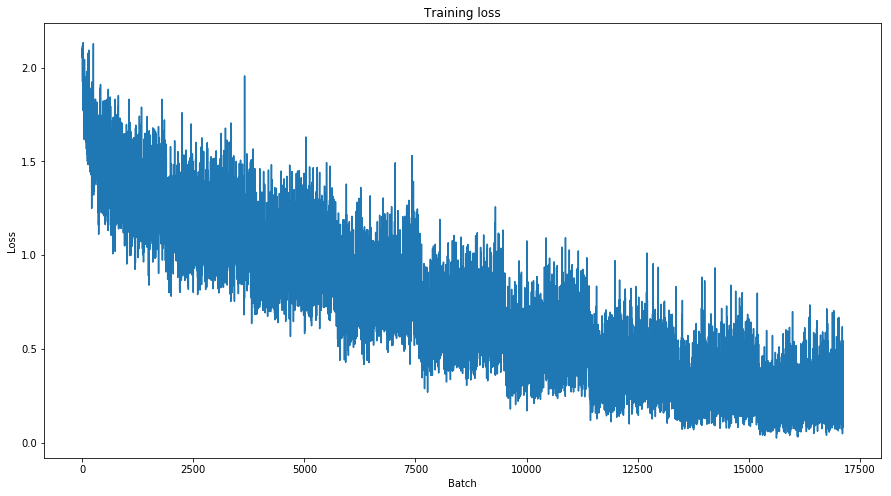

In [34]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()


***TESTING PHASE***

In [35]:
test_loss, test_accuracy,F1_score_test, F2_score_test = 0, 0,0,0
nb_eval_steps, nb_test_examples = 0, 0

model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in testing_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()  
    # Store predictions and true labels
    tmp_test_accuracy = flat_accuracy(logits, label_ids)
    
    f1 = f1_macro(logits, label_ids)

    f2 = f1_weighted(logits, label_ids)

    F1_score_test+=f1
    F2_score_test+=f2
    test_accuracy += tmp_test_accuracy
    nb_eval_steps += 1

print("F1 score(macro): {}".format(F1_score_test/nb_eval_steps))
print("F1 score(weighted): {}".format(F2_score_test/nb_eval_steps))
print("Test Accuracy: {}".format(test_accuracy/nb_eval_steps))

F1 score(macro): 0.4107734226434017
F1 score(weighted): 0.48150433506486956
Test Accuracy: 0.47911347517730496
